<a href="https://colab.research.google.com/github.com/Fra-Sala/gnn_time/blob/main/notebook/11_lid_cavity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

/home/francesco/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [3]:
# Clone and/or import gca-rom
import sys
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/Fra-Sala/gnn_time.git
    sys.path.append('./gnn_time/gca_time')
else:
    sys.path.append('./..')
    
from gca_time import network, pde, loader, plotting, preprocessing, training, initialization, testing, error, gui


In [4]:
import numpy as np
from itertools import product

# Define PDE problem

In [5]:
problem_name, variable, mu_space,n_param = pde.problem(12)
params = mu_space[0]
time = mu_space[1]
print("\nProblem: ", problem_name)
print("Variable: ", variable)
print("Simulations: ", n_param)
argv = gui.hyperparameters_selection(problem_name, variable, n_param)

# Overwrite some selections
argv[5] = 90  # 70% of the space parameter is used for training
argv[8] = 10  # Dimension of latent state
argv[12] = 2500 # number of epochs

HyperParams = network.HyperParams(argv)


Problem:  lid_cavity
Variable:  VX_VY
Simulations:  20


Here params and time are numpy ndarray

# Initialize device and set reproducibility

In [6]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)
initialization.set_path(HyperParams)
device = "cpu"

Device used:  cuda


In [7]:
# import os
# OMP_NUM_THREADS = int(os.getenv('OMP_NUM_THREADS', 4))  # Default to 1 if the env var is not set
# torch.set_num_threads(OMP_NUM_THREADS)
# torch.set_num_interop_threads(OMP_NUM_THREADS)

# Load dataset

In [8]:
if 'google.colab' in str(get_ipython()):
    dataset_dir = '/content/gnn_time/gca_time/dataset/'+problem_name+'_unstructured.mat'
else:
    dataset_dir = '../dataset/'+problem_name+'_unstructured.mat'
       
# Note that loader has been changed to create only float tensors
dataset = loader.LoadDataset(dataset_dir, variable, dim_velocity=2)
def delete_initial_condition(dataset, dim=2):
    if dim == 1:
        indices = torch.ones(dataset.U.shape[1], dtype=torch.bool)
        indices[::10] = 0
        dataset.U = dataset.U[:, indices]
    elif dim == 2:
        indices = torch.ones(dataset.VX.shape[1], dtype=torch.bool)
        indices[::10] = 0
        dataset.VX = dataset.VX[:, indices]
        dataset.VY = dataset.VY[:, indices]
    else:
        print("Invalid dimension. Please enter 1 or 2.")
    return dataset
# def delete_initial_condition(dataset, dim=2):
#     if dim == 1:
#         dataset.U = np.delete(dataset.U, np.s_[::10], 1)
#     elif dim == 2:
#         dataset.VX = np.delete(dataset.VX, np.s_[::10], 1)
#         dataset.VY = np.delete(dataset.VY, np.s_[::10], 1)
#     else:
#         print("Invalid dimension. Please enter 1 or 2.")
#     return dataset

dataset = delete_initial_condition(dataset, dim=2)

## Shrink dataset (debugging/define a rate for the time extrapolation)

In [9]:
num_sim2keep = 20 # not greater than 20, in total (train and test, before application of train_rate)
num_snap2keep = 7 # # not greater than 9
# Note that setting num_snap2keep < 9 allows for time extrapolation: take the model trained on 7 snaps
# then change num_snap2keep to 9 and run the notebook again

def shrink_dataset(dataset, params, time, num_sim, num_snap_per_sim, dim=2):
    new_time = time[:num_snap_per_sim+1]
    new_params = params[:num_sim]
    
    if dim == 1:
        new_U = []
        new_XX = []
        new_YY = []
        for i in range(num_sim):
            start = i * (len(time) - 1)
            end = start + num_snap_per_sim
            new_U.append(dataset.U[:, start:end])
            new_XX.append(dataset.xx[:, start:end])
            new_YY.append(dataset.yy[:, start:end])
        new_U = np.concatenate(new_U, axis=1)
        new_XX = np.concatenate(new_XX, axis=1)
        new_YY = np.concatenate(new_YY, axis=1)

        return new_U, new_XX, new_time, new_params
    elif dim == 2:
        new_VX = []
        new_VY = []
        new_XX = []
        new_YY = []
        for i in range(num_sim):
            start = i * (len(time) - 1)
            end = start + num_snap_per_sim
            new_VX.append(dataset.VX[:, start:end])
            new_VY.append(dataset.VY[:, start:end])
            new_XX.append(dataset.xx[:, start:end])
            new_YY.append(dataset.yy[:, start:end])
        new_VX = np.concatenate(new_VX, axis=1)
        new_VY = np.concatenate(new_VY, axis=1)
        new_XX = np.concatenate(new_XX, axis=1)
        new_YY = np.concatenate(new_YY, axis=1)
    
        return torch.tensor(new_VX, dtype=torch.float32), torch.tensor(new_VY, dtype=torch.float32), torch.tensor(new_XX, dtype=torch.float32),\
                         torch.tensor(new_YY, dtype=torch.float32), new_time, new_params

dataset.VX, dataset.VY, dataset.xx, dataset.yy, time, params = shrink_dataset(dataset, params, time, num_sim2keep, num_snap2keep, dim=2)

time = torch.from_numpy(time)
time = time.to(dtype=torch.float32)
params = torch.from_numpy(params)
params = params.to(dtype = torch.float32)

print("Number of simulations (series of snaps):", params.shape[0])
print("Number of instants of time (initial time excluded):", time.shape[0]-1)

Number of simulations (series of snaps): 20
Number of instants of time (initial time excluded): 7


In [10]:

graph_loader, train_loader, test_loader, \
    val_loader, scaler_all, scaler_test, xyz, VAR_all, VAR_test, \
        train_trajectories, test_trajectories, params_train, params_test = preprocessing.graphs_dataset(dataset, HyperParams, params)



Number of nodes processed:  15681
Number of graphs processed:  140
Length of train dataset:  126
Length of test dataset:  14


# Define the architecture

In [11]:

model_decoder = network.Net(HyperParams)
model_dyn = network.DynNet(HyperParams)
model_decoder = model_decoder.to(device)
model_dyn = model_dyn.to(device)

torch.set_default_dtype(torch.float32)
optimizer = torch.optim.Adam([
    {'params': model_dyn.parameters()},
    {'params': model_decoder.parameters()}
], lr=HyperParams.learning_rate,  weight_decay=HyperParams.weight_decay)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

# Train or load a pre-trained network

In [12]:
try:
    model_decoder.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'_decoder.pt', map_location=torch.device('cpu')))
    model_dyn.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'_dyn.pt', map_location=torch.device('cpu')))
    print('Loading saved network')
except FileNotFoundError:
    print('Training network')
    import cProfile
    training.train(model_decoder, model_dyn, optimizer, device, scheduler, train_loader, test_loader, HyperParams, params_train, params_test, time)
    plotting.plot_loss(HyperParams)

Loading saved network


# Evaluate the model

In [13]:
model_decoder.to("cpu")
model_dyn.to("cpu")
results, latents = testing.evaluate(VAR_all, model_decoder, model_dyn, graph_loader, params, time, HyperParams)


Evaluating the model...
Evaluation complete!


In [14]:
time

tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000, 1.2000, 1.4000])

# Plot the results

In [15]:
# Create arrays that contain one \mu and t for each snapshot of the dataset, to quickly retrieve both parameters for a given SNAP
params = params.numpy()
params_train = params_train.numpy()
time = time.numpy()
PARAMS = np.repeat(params, len(time)-1, axis=0)
TIMES = np.tile(time[1:], params.shape[0])


### Time extrapolation capability

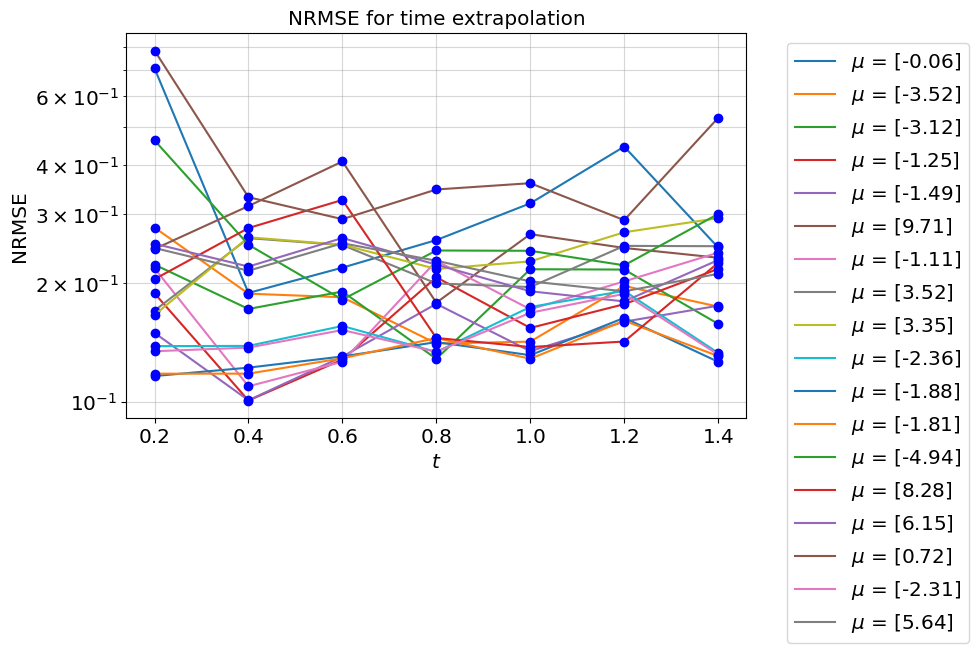

In [16]:
# We consider only parameters that were used for training, and we see how the model predicts the evolution of the system
# over unseen instants of time. The marker changes when moving from training to test data in time.
# If you want to see how the model behaves in time extrapolation, train the network on num_snap2keep <9. Then, set num_snap2keep = 9 and run the notebook.
# but do NOT change the number of num_sim2keep, otherwise you will see plotted training data that the network has never seen.
# This is because the notebook is not yet structured to deal with both time extrapolation and parameter extrapolation.
plotting.plot_time_extrapolation(results, scaler_all, HyperParams, dataset, params_train, time, n_train_instants = 7 )

# Blue dots denote training data, red crosses denote testing data

### Performance over time and parameter space 

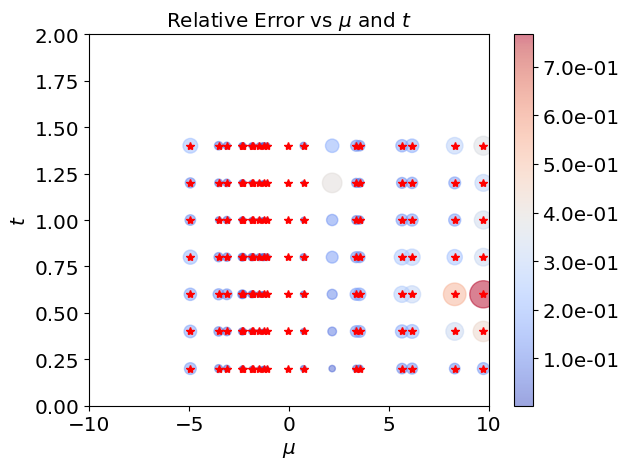

In [17]:
plotting.plot_error(results, dataset, scaler_all, HyperParams, params, PARAMS, time[1:], TIMES, train_trajectories)

### Visualize predicted and error fields

In [18]:
# If you want to see how the model behaves in time extrapolation, train the network on num_snap2keep <9. Then, set num_snap2keep = 9 and run the notebook.
snapshots = test_trajectories
# note that the indices snapshots are global (the first snapshot of test_trajectories is NOT 0)
for SNAP in snapshots:
    plotting.plot_latent(SNAP, latents, params, time, HyperParams)
    plotting.plot_fields(SNAP, results, scaler_all, HyperParams, dataset, PARAMS, TIMES)


# Print the errors on the testing set

In [21]:
error_abs, norm = error.compute_error(results, dataset, scaler_all, HyperParams, test_trajectories)
vars = 'GCA-TIME'
error.print_error(error_abs, norm, vars)
error.save_error(error_abs, norm, HyperParams, vars)


Maximum absolute error for field GCA-TIME =  20.695722677976402
Mean absolute error for field GCA-TIME =  4.736436807247372
Minimum absolute error for field GCA-TIME =  0.9133346652268521

Maximum relative error for field GCA-TIME =  0.877564265394457
Mean relative error for field GCA-TIME =  0.17456072745161227
Minimum relative error for field GCA-TIME =  0.03762681987611456


In [20]:
dataset.

SyntaxError: invalid syntax (2401907427.py, line 1)